In [1]:
import random
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
import tensorflow as tf
from IPython import get_ipython
from keras.backend.tensorflow_backend import set_session
from tqdm import tqdm
from collections import Counter

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

plt.ion()
plt.show()
sys.path.append("..")

random_state=0
random.seed( random_state )
np.random.seed(random_state)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# filename ="BRCA"
filename ="KIRP"
if filename == "KIRP":
    ground_truth_subspace = 9
else:
    ground_truth_subspace = 1

In [4]:
data = pd.read_pickle(f"data/rna_data/{filename}.pkl")
additional_df = pd.read_pickle(f"data/rna_data/{filename}_additional.pkl")
truth = data["y"].values
data = data.drop("y", axis = 1).values
n_clusters = len(np.unique(truth))
Counter(truth), data.shape

(Counter({0: 77, 1: 86}), (163, 17938))

In [5]:
# method = "adapted_silhouette"
# clustering = "hdbscan"

In [6]:
clustering = "gmm"
method = "adapted_ratkowsky_lance"

In [7]:
solutions = pd.read_pickle(f"data/{filename}_{clustering}_{method}.pkl")
solutions

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.278408,-0.00,"[4332, 11017]","[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...",2.0,"Counter({1: 126, 0: 37})"
1,0.278181,0.00,"[6784, 8892]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",2.0,"Counter({0: 125, 1: 38})"
2,0.276569,-0.00,"[51, 163, 181, 308, 351, 561, 755, 812, 816, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",177.0,"Counter({0: 150, 1: 13})"
3,0.310809,-0.01,"[4187, 4188, 4329, 4935, 8012, 12291, 13404, 1...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...",11.0,"Counter({0: 116, 1: 47})"
4,0.256949,0.01,"[7220, 7230, 7231]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"Counter({0: 150, 1: 13})"
5,0.269851,0.09,"[461, 462, 5126, 6138, 6267, 6835, 9560, 10770...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",20.0,"Counter({0: 117, 1: 46})"
6,0.241033,-0.00,"[140, 237, 241, 283, 357, 448, 632, 653, 758, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",301.0,"Counter({0: 118, 1: 45})"
7,0.233363,-0.00,"[593, 594, 1469, 4943, 12097]","[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, ...",5.0,"Counter({0: 89, 1: 74})"
8,0.237996,0.01,"[6286, 8434]","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2.0,"Counter({0: 125, 1: 38})"
9,0.222330,0.18,"[17, 91, 358, 864, 1218, 1348, 1856, 1865, 188...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...",109.0,"Counter({0: 101, 1: 62})"


In [ ]:
# solutions = pd.read_pickle(f"data/rna_data/{filename}_solutions.pkl")
# solutions

In [9]:
subspaces = solutions["features"].values
partitions = solutions["partition"].values

In [10]:
# for i in range(10):
#     predK = KMeans(n_clusters=n_clusters,
#                            random_state=0).fit(data[: , subspaces[i]]).labels_

#     print(adjusted_rand_score(predK, partitions[i]), Counter(predK == partitions[i]))

# Number of missing clinical data


In [11]:
# (additional_df.isnull().sum()/additional_df.shape[0]).mean()

In [12]:
additional_results, best_subspace_match, best_meta_subspace = bio_analysis.clinical_data_analysis(
    additional_df, solutions, n_clusters)

Found 2 values for vital_status
Clustering numeric values for days_to_death
Clustering numeric values for days_to_last_followup
No more than 1 class found for additional_studies
Found 3 values for additional_surgery_locoregional_procedure
No more than 1 class found for additional_surgery_metastatic_procedure
Clustering numeric values for age_at_initial_pathologic_diagnosis
Found 11 values for anatomic_neoplasm_subdivision-2
Found 9 values for anatomic_neoplasm_subdivision-3
Found 6 values for anatomic_neoplasm_subdivision-4
Found 5 values for anatomic_neoplasm_subdivision-5
Found 10 values for anatomic_neoplasm_subdivision
Found 6 values for axillary_lymph_node_stage_method_type
Found 19 values for axillary_lymph_node_stage_other_method_descriptive_text
No more than 1 class found for b_symptoms
No more than 1 class found for bcr
Found 3 values for bcr_canonical_reason-2
No more than 1 class found for bcr_canonical_reason-3
Found 6 values for bcr_canonical_reason
Found 942 values for bc

In [13]:
best_subspace_match["additional_data"].unique()

array(['breast_carcinoma_estrogen_receptor_status',
       'bcr_canonical_reason-2', 'bcr_canonical_reason',
       'metastatic_site_at_diagnosis_other',
       'additional_surgery_locoregional_procedure',
       'metastatic_site_at_diagnosis-2'], dtype=object)

In [14]:
best_subspace_match

,subspace,ari,additional_data,n
0,0,0.32,breast_carcinoma_estrogen_receptor_status,1031
1,1,0.68,breast_carcinoma_estrogen_receptor_status,1031
2,2,0.28,bcr_canonical_reason-2,95
3,3,0.42,bcr_canonical_reason,139
4,4,0.46,bcr_canonical_reason-2,95
5,5,0.40,bcr_canonical_reason-2,95
6,6,0.35,bcr_canonical_reason-2,95
7,7,0.36,metastatic_site_at_diagnosis_other,7
8,8,0.13,additional_surgery_locoregional_procedure,55
9,9,0.16,metastatic_site_at_diagnosis-2,7


In [18]:
maping = {
    'breast_carcinoma_estrogen_receptor_status': "Carcinoma Estrogen Receptor",
    'metastatic_site_at_diagnosis-2': "Metastatic site 2",
    'bcr_canonical_reason': "Canonical reason",
    'anatomic_neoplasm_subdivision-4': "Neoplasm subdivision 4",
    'pos_finding_her2_erbb2_other_measurement_scale_text': "Her2 Erbb2",
    'bcr_canonical_reason-2': "Canonical reason 2",
    "days_to_additional_surgery_metastatic_procedure":
    "Days to additional surgery",
    "metastatic_site_at_diagnosis_other": "Metastatic site",
    'bcr_patient_canonical_status': "BCR Canonical Status",
    'bcr_canonical_reason-2': "BCR Canonical Reason 2",
    'erythrocyte_sedimentation_rate_result': "Erythrocyte Sedimentation",
    'gender': "Gender",
    'clinical_stage': "Clinical Stage",
    'karnofsky_performance_score': "Karnofsky performance",
    'serum_calcium_result': "Serum Calcium Result",
    'lymph_node_examined_count': "Lymph count",
    'eastern_cancer_oncology_group': "Eastern oncology group",
    'days_to_death': "Days to death",
    'year_of_tobacco_smoking_onset': "Year smoking onset",
    'followup_treatment_success': "Followup treatment success",
    'performance_status_scale_timing': "Status Scale Timing",
    "additional_surgery_locoregional_procedure": "Additional Locoregional Procedure"
}

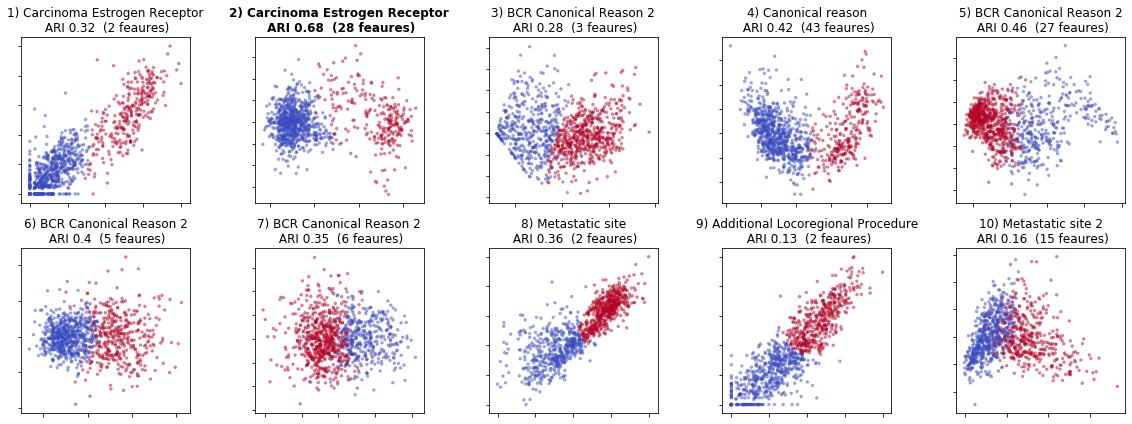

In [19]:
bio_analysis.plot_subspaces_with_best_meta(solutions,
                                           best_subspace_match,
                                           data,
                                           ground_truth_subspace,
                                           maping,
                                           do_pca=True,
                                           filename =  f"images/{filename}_subspaces_PCA.pdf")

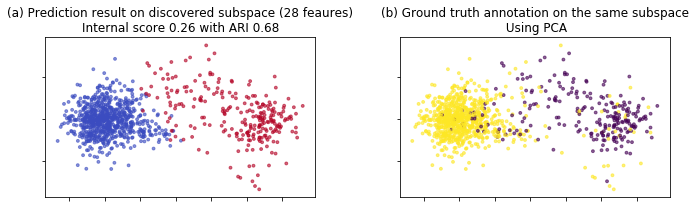

In [20]:
bio_analysis.plot_prediction_vs_ground_truth(ground_truth_subspace, solutions, data, truth, do_pca = True,
            filename = f"images/{filename}_pred_vs_gt.pdf")


In [21]:
bio_analysis.solutions_to_survival_analysis(
    additional_df, solutions, f"data/rna_data/{filename}_survival.pkl")

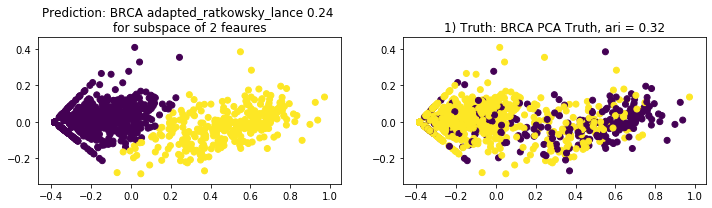

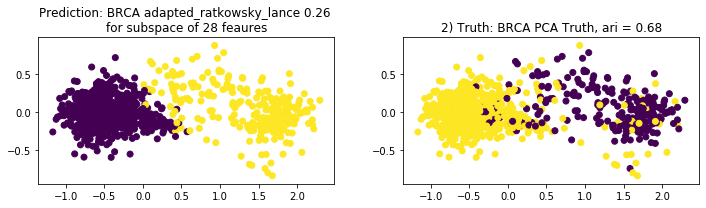

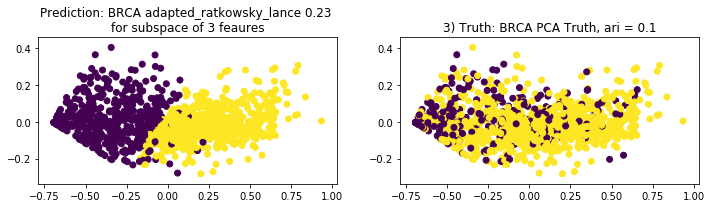

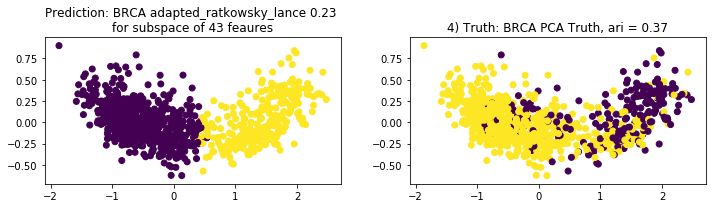

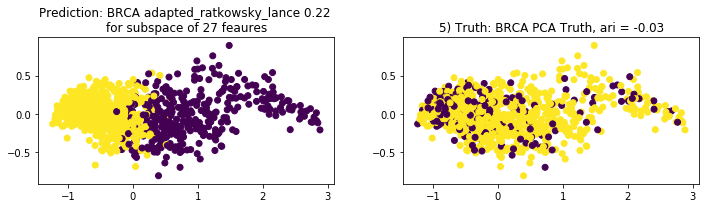

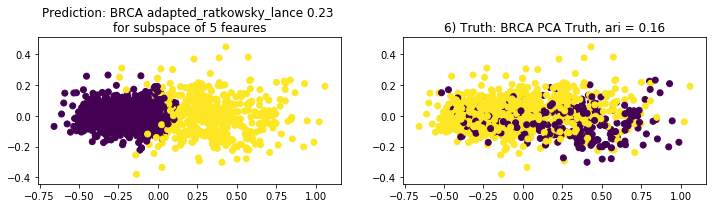

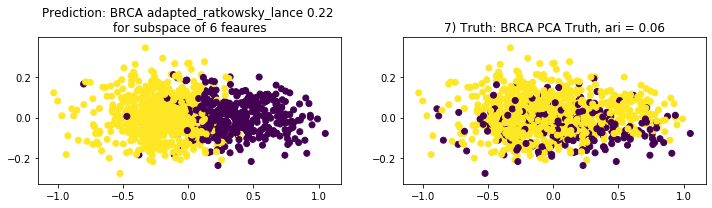

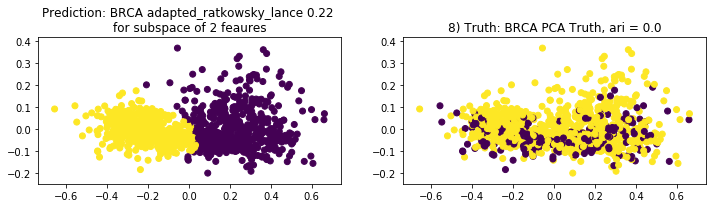

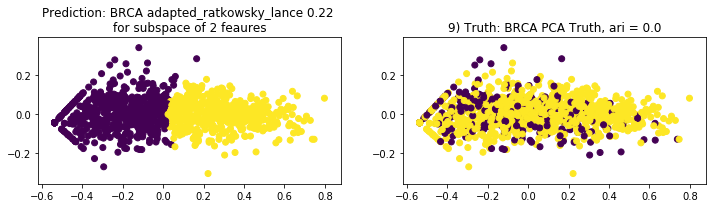

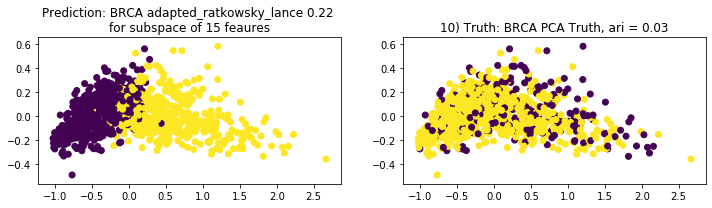

In [22]:
pdf_name =f"reports/{filename}.pdf"
bio_analysis.plot_pca_subspaces(data, solutions, method, truth, pdf_name = None, name = filename)

In [ ]:
merged = bio_analysis.merge_subspaces(solutions, method, data, n_clusters, truth)

# Gender analysis

In [8]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import cluster, datasets, mixture

In [9]:
c = 'gender'

additional_df['gender' ].isnull().sum()

not_null_idx = additional_df[~additional_df[c].isnull(
            )].index.values

labels = preprocessing.LabelEncoder().fit_transform(
                    additional_df[c].values[not_null_idx])

In [10]:
# for i in range(20):
#     print(i, adjusted_rand_score(labels, solutions.iloc[i]['partition']))

In [12]:
sid = 3

target_subspace = solutions.iloc[sid]['features']

adjusted_rand_score(labels, solutions.iloc[sid]['partition']), len(target_subspace)

(0.9746445225088622, 11)

In [ ]:
labels = np.abs(labels -1)

In [ ]:
mislabelled = np.where(labels!= solutions.iloc[sid]['partition'])[0]

In [ ]:
len(mislabelled)

In [ ]:
do_pca = True
data_x = data[:, target_subspace]
if do_pca:
    pca_data = PCA(n_components=2).fit_transform(data_x)
else:
    pca_data = TSNE(n_components=2).fit_transform(data_x)

In [ ]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= solutions.iloc[sid]['partition'], 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled, 0], pca_data[mislabelled, 1], c = "black", marker = '*', s =150) 
plt.title("Gender analysis")

plt.savefig("images/gender_analysis.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (12, 4))
predGender = KMeans(n_clusters=n_clusters,
                       random_state=0).fit(data[: , target_subspace]).labels_
mislabelled1 = np.where(labels!= predGender)[0]
print(len(mislabelled1))
plt.subplot(121)
plt.title(f"(a) KMeans prediction on {len(target_subspace)} features gender subspace" + 
         f"\nRepresesented as 2D PCA ({len(mislabelled1)} mislabelled patients)")
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= predGender, 
            cmap = "coolwarm", alpha = 0.4, s = 50)
plt.scatter(pca_data[mislabelled1, 0], pca_data[mislabelled1, 1], c = "black", marker = '*', s =150) 

spectral = cluster.SpectralClustering(
        n_clusters=2, eigen_solver='arpack',
        affinity="nearest_neighbors").fit(data[: ,  solutions.iloc[sid]['features']])
predGender = spectral.labels_
predGender = np.abs(predGender-1)

mislabelled1 = np.where(labels!= predGender)[0]
print(len(mislabelled1))
plt.subplot(122)
plt.title(f"(b) Spectral clustering prediction on {len(target_subspace)} features gender subspace" + 
         f"\nRepresesented as 2D PCA ({len(mislabelled1)} mislabelled patients)")
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= predGender, 
            cmap = "coolwarm", alpha = 0.4, s = 50)
plt.scatter(pca_data[mislabelled1, 0], pca_data[mislabelled1, 1], c = "black", marker = '*', s =150) 
plt.tight_layout()

plt.savefig("images/gender_analysis.pdf", bbox_inches='tight')

In [ ]:
predGender = KMeans(n_clusters=n_clusters,
                       random_state=0).fit(data[: ,  target_subspace]).labels_
mislabelled1 = np.where(labels!= predGender)[0]
print(len(mislabelled1))

plt.scatter(pca_data[:, 0], pca_data[:, 1], c= predGender, 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled1, 0], pca_data[mislabelled1, 1], c = "black", marker = '*', s =150) 

In [ ]:
mislabelled1 = np.where(labels!= predGender)[0]

In [ ]:
for j in target_subspace:
    pp = KMeans(n_clusters=n_clusters,
                           random_state=0).fit(data[: ,  target_subspace[:2]]).labels_
    break

In [ ]:
adjusted_rand_score(labels, pp)

In [ ]:
plt.hist(data[: ,  j][np.where(pp ==0 )[0]])

In [ ]:
print(len(mislabelled1))

plt.scatter(pca_data[:, 0], pca_data[:, 1], c= predGender, 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled1, 0], pca_data[mislabelled1, 1], c = "black", marker = '*', s =150) 

In [ ]:
for i in range(len(target_subspace)):
    predGender = KMeans(n_clusters=n_clusters,
                           random_state=0).fit(data[: ,np.delete(target_subspace,i)]).labels_
                                               
    print(f"{i}, {adjusted_rand_score(labels, predGender)} ")